# Success rates vs number of structures for docking

This notebook explores the effect of the number of available structures on cross-docking performance.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)
posit_template_results = pd.read_csv("../data/posit_template_results.csv", index_col=0)

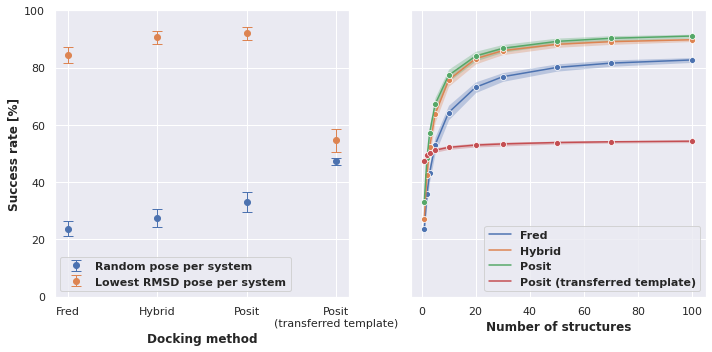

In [5]:
def plot_success_vs_structure_numbers(fred_results, hybrid_results, posit_results, posit_template_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # 2 subplots
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]    
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # condensed docking method success rates
    # sample results
    sampled_success_rates = []
    for i, (method, results) in enumerate(zip(
        ["Fred", "Hybrid", "Posit", "Posit\n(transferred template)"], 
        [fred_results, hybrid_results, posit_results, posit_template_results]
    )):
        for j, focus in enumerate(["Random pose per system", "Lowest RMSD pose per system"]):
            sampled_success_rates_i = []
            if focus == "Lowest RMSD pose per system":
                selected_results = results.sort_values("rmsd")
                selected_results = selected_results.groupby(["ligand_pdb_id"]).head(1)
                success_labels = (selected_results["rmsd"] <= 2).to_list()
            for _ in range(n_bootstrap):
                if focus == "Random pose per system":
                    sampled_results = results.groupby("ligand_pdb_id").sample(n=1, replace=True)
                    sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                else:
                    sampled_success_labels = resample(success_labels, replace=True)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([
                method,
                focus,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])    
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, columns=["method", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
    
    # first plot
    sampled_success_rates_all = sampled_success_rates[sampled_success_rates["focus"] == "Random pose per system"]
    axes[0].errorbar(
            x=sampled_success_rates_all["method"],
            y=sampled_success_rates_all["success_rate"],
            yerr=[
                sampled_success_rates_all["success_rate"] - sampled_success_rates_all["ci_lower"], 
                sampled_success_rates_all["ci_upper"] - sampled_success_rates_all["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1,
            label="Random pose per system"
        )
    sampled_success_rates_best = sampled_success_rates[sampled_success_rates["focus"] == "Lowest RMSD pose per system"]
    axes[0].errorbar(
            x=sampled_success_rates_best["method"],
            y=sampled_success_rates_best["success_rate"],
            yerr=[
                sampled_success_rates_best["success_rate"] - sampled_success_rates_best["ci_lower"], 
                sampled_success_rates_best["ci_upper"] - sampled_success_rates_best["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1,
            label="Lowest RMSD pose per system"
        )
    axes[0].set_xlabel("Docking method", fontweight="bold")
    axes[0].set_ylabel("Success rate [%]", fontweight="bold")
    axes[0].legend(prop=dict(weight="bold"), fancybox=True)
    
    # success vs structure number
    # sample results
    sampled_success_rates_2 = []
    for method, results in zip(
        ["Fred", "Hybrid", "Posit", "Posit (transferred template)"], 
        [fred_results, hybrid_results, posit_results, posit_template_results]
    ):
        for structure_number in [1, 2, 3, 5, 10, 20, 30, 50, 70, 100]:
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = results.groupby("ligand_pdb_id").sample(structure_number, replace=True)
                # sort by rmsd
                sampled_results = sampled_results.sort_values("rmsd")
                # pick the lowest RMSD pose per system
                sampled_results = sampled_results.groupby(["ligand_pdb_id"]).head(1)
                sampled_success_labels = [1 if x <= 2 else 0 for x in sampled_results["rmsd"]]
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates_2.append([structure_number, method, mean, lower_bound, upper_bound])
    sampled_success_rates_2 = pd.DataFrame(
        sampled_success_rates_2, 
        columns=["n_structures", "method", "success_rate", "ci_lower", "ci_upper"]
    )
    # plot mean
    sns.lineplot(data=sampled_success_rates_2, x="n_structures", y="success_rate", hue="method", marker="o", ci=None, ax=axes[1])
    axes[1].set_ylim([0, 100])
    axes[1].set_xlabel("Number of structures", fontweight="bold")
    axes[1].legend(prop=dict(weight="bold"), fancybox=True)
    # plot ci
    axes[1].fill_between(
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Fred"]["n_structures"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= axes[1].get_lines()[0].get_color(),
        linewidth=0
    )
    axes[1].fill_between(
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Hybrid"]["n_structures"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= axes[1].get_lines()[1].get_color(),
        linewidth=0
    )
    axes[1].fill_between(
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Posit"]["n_structures"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= axes[1].get_lines()[2].get_color(),
        linewidth=0
    )
    axes[1].fill_between(
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Posit (transferred template)"]["n_structures"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Posit (transferred template)"]["ci_lower"], 
        sampled_success_rates_2[sampled_success_rates_2["method"] == "Posit (transferred template)"]["ci_upper"], 
        alpha=0.3,
        color= axes[1].get_lines()[3].get_color(),
        linewidth=0
    )
    plt.tight_layout()
    plt.savefig(directory / "success_vs_structure_number.pdf", dpi=300)
    
    return sampled_success_rates, sampled_success_rates_2
    
sampled_success_rates, sampled_success_rates_2 = plot_success_vs_structure_numbers(
    fred_results, hybrid_results, posit_results, posit_template_results
)

In [6]:
sampled_success_rates

,method,focus,success_rate,ci_lower,ci_upper
0,Fred,Random pose per system,23.807980,21.222411,26.485569
1,Fred,Lowest RMSD pose per system,84.367402,81.494058,87.266553
2,Hybrid,Random pose per system,27.332088,24.278438,30.560272
3,Hybrid,Lowest RMSD pose per system,90.654839,88.285229,92.869270
4,Posit,Random pose per system,32.993379,29.711375,36.672326
5,Posit,Lowest RMSD pose per system,92.168930,89.813243,94.227504
6,Posit\n(transferred template),Random pose per system,47.294037,46.166951,48.551959
7,Posit\n(transferred template),Lowest RMSD pose per system,54.613629,50.596252,58.603066


In [7]:
sampled_success_rates_2

,n_structures,method,success_rate,ci_lower,ci_upper
0,1,Fred,23.770119,21.052632,26.655348
1,2,Fred,35.877929,32.767402,38.879457
2,3,Fred,43.338200,40.407470,46.179966
3,5,Fred,52.970119,50.084890,55.857385
4,10,Fred,64.314601,61.799660,66.893039
5,20,Fred,73.156537,71.307301,75.042445
6,30,Fred,76.836333,75.212224,78.268251
7,50,Fred,80.075891,78.777589,81.324278
8,70,Fred,81.588455,80.475382,82.682513
9,100,Fred,82.700679,81.833616,83.531409
